# Postprocessing

The Isoforce data is recorded using three different channels named:

- **P** $\rightarrow \quad \text{Position}$ `AI0`
- **T** $\rightarrow \quad \text{Torque}$ `AI1`
- **S** $\rightarrow \quad \text{Speed}$ `AI2`

During the postprocessing, the global parameter name is used as follows with the corresponding class.

- **P** $\rightarrow \quad \text{Angle}$ `AI0` $\rightarrow$ `IsoforceIso.angle` colored in red (C3)
- **T** $\rightarrow \quad \text{Torque}$ `AI1` $\rightarrow$ `IsoforceIso.torque` colored in blue (C0)
- **S** $\rightarrow \quad \text{Speed}$ `AI2` $\rightarrow$ `IsoforceIso.speed` colored in yellow (C8)

**Set data path**

In [1]:
path = "measurements/Participant_test1/"

## Start postprocessing

- `isoforce_iso` contains the data recorded with the Isoforce
- `isoforce_py_raw` contains the Isoforce data recorded with the Python script
- `sciospec_EIT_raw` contains the EIT data recorded with the EIT device

In [2]:
import os
from glob import glob

import matplotlib.pyplot as plt
import numpy as np

from src.postprocessing import (
    IsoforceIso,
    ProcessingDir,
    process_sciospec_eit,
    renderDF,
    scale_to_range,
)

In [3]:
part_path = ProcessingDir(path)

Fund participant data:

Head directory: self.path='measurements/Participant_test1/'
Raw Isoforce data measured by Isoforce:
	self.isoforce_iso='measurements/Participant_test1/Test_1_JO_raw_data_10012025154959.txt'
Raw Isoforce data measured by Python:
	self.isoforce_py_raw='measurements/Participant_test1/Isokinetic_raw/'
Raw sciospec EIT data:
	self.sciospec_EIT_raw='measurements/Participant_test1/EIT_raw/'
Raw sciospec EIT samples:
	self.EIT_samples_raw='measurements/Participant_test1/EIT_raw/20250113 09.24.18/setup/'
Preprocessed sciospec EIT samples:
	self.s_path_eit='measurements/Participant_test1/EIT_processed/'


In [4]:
DF = renderDF(part_path.isoforce_iso)

!!!The torque data is lowpass filtered!!!


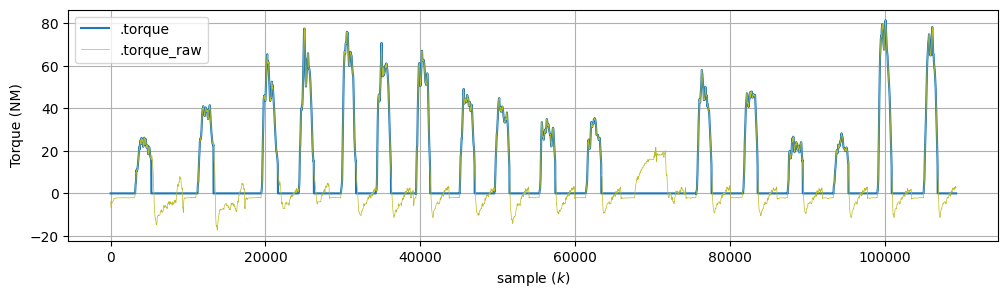

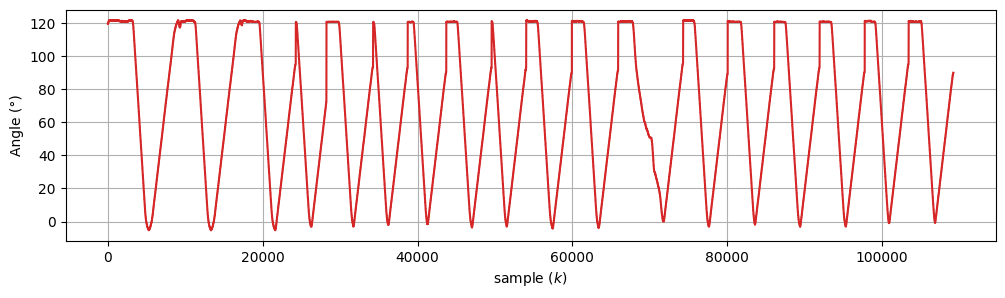

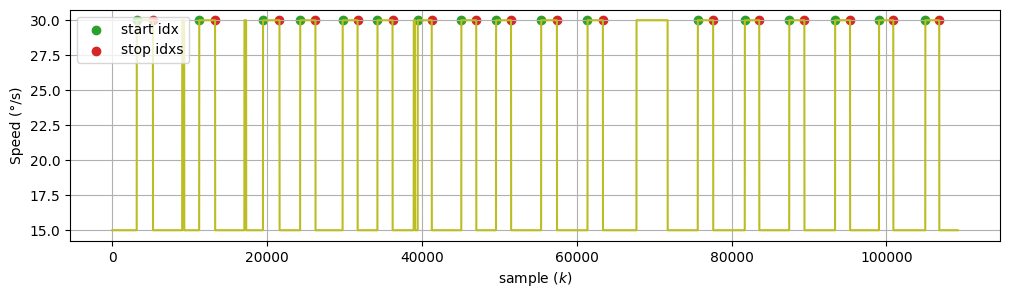

In [5]:
isoforce_iso = IsoforceIso(DF, LP_filter=True)
isoforce_iso.plot_torque()
isoforce_iso.plot_angle()
isoforce_iso.plot_speed()

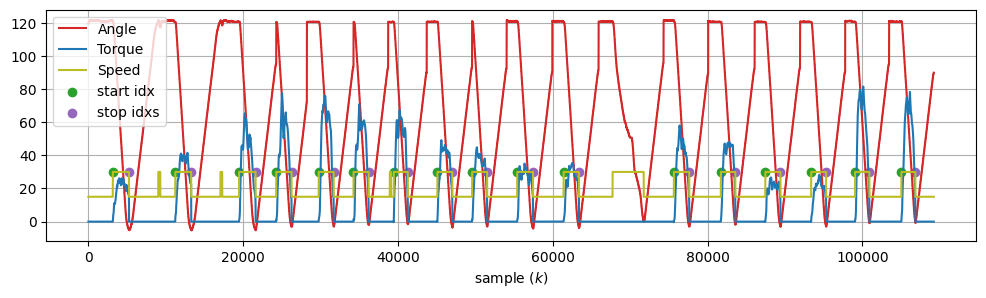

In [6]:
isoforce_iso.plot_data()

/tmp/ipykernel_46955/3462517923.py:3: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


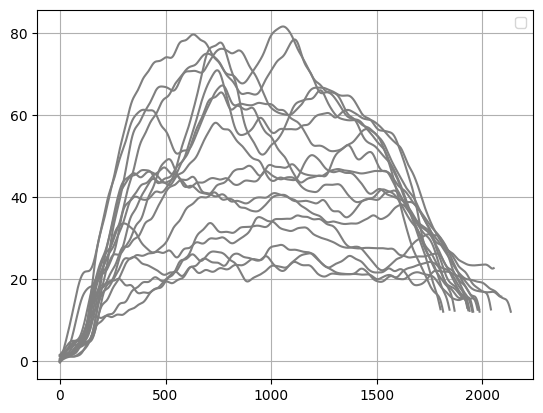

In [7]:
for key in isoforce_iso.torque_segments.keys():
    plt.plot(isoforce_iso.torque_segments[key], "C7")
plt.legend()
plt.grid()
plt.show()

**EIT Sciospec raw**

In [8]:
part_path.print_info()

Fund participant data:

Head directory: self.path='measurements/Participant_test1/'
Raw Isoforce data measured by Isoforce:
	self.isoforce_iso='measurements/Participant_test1/Test_1_JO_raw_data_10012025154959.txt'
Raw Isoforce data measured by Python:
	self.isoforce_py_raw='measurements/Participant_test1/Isokinetic_raw/'
Raw sciospec EIT data:
	self.sciospec_EIT_raw='measurements/Participant_test1/EIT_raw/'
Raw sciospec EIT samples:
	self.EIT_samples_raw='measurements/Participant_test1/EIT_raw/20250113 09.24.18/setup/'
Preprocessed sciospec EIT samples:
	self.s_path_eit='measurements/Participant_test1/EIT_processed/'


In [9]:
try:
    os.mkdir(part_path.s_path_eit)
    process_sciospec_eit(part_path)
except BaseException:
    print("Directory already exists.")

Directory already exists.


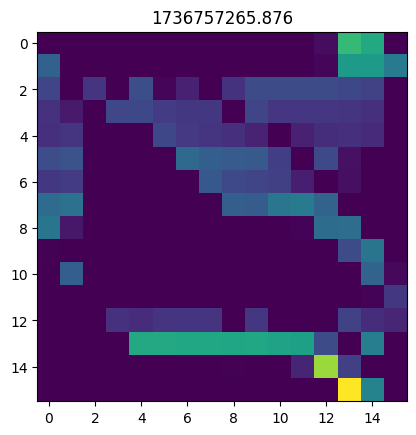

In [10]:
tmp = np.load(part_path.s_path_eit + "setup_00002.npz", allow_pickle=True)
tmp_2 = np.load(part_path.s_path_eit + "setup_00003.npz", allow_pickle=True)
tmp.files

plt.title(tmp["timestamp"])
plt.imshow(np.abs(tmp["eit"]))
plt.show()

**Isoforce Python raw**

- Ch_1, P = Angle = red (C3) {Factor = 54, Offset = 12}
- Ch_2, T = Torque = blue (C0) {Factor = 150, Offset = 24}
- Ch_3, S = Speed = yellow (C8) {Factor = 108, Offset = -4}

In [11]:
part_path.isoforce_py_raw

'measurements/Participant_test1/Isokinetic_raw/'

In [12]:
from src.postprocessing import IsoforcePy

In [13]:
isoforce_py = IsoforcePy(part_path.isoforce_py_raw, LP_filter=True, over_UTC=False)

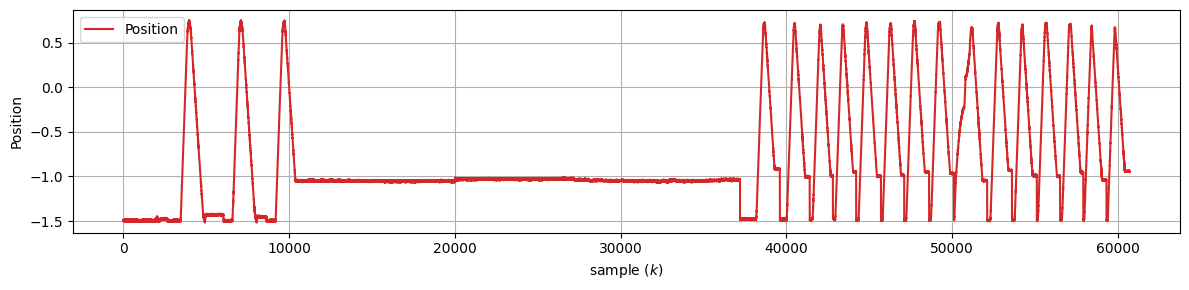

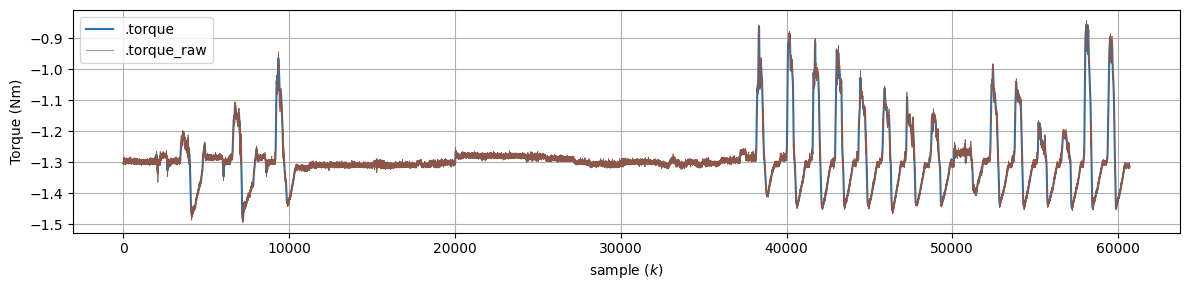

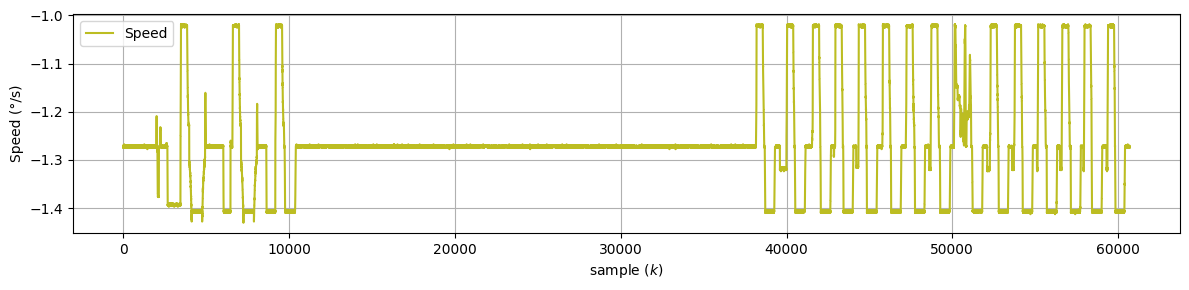

In [14]:
isoforce_py.plot_angle()
isoforce_py.plot_torque()
isoforce_py.plot_speed()

- Ch_1, P = Position = red (C3) {Factor = 54, Offset = 12}
- Ch_2, T = Torque = blue (C0) {Factor = 150, Offset = 24}
- Ch_3, S = Speed = yellow (C8) {Factor = 108, Offset = -4}

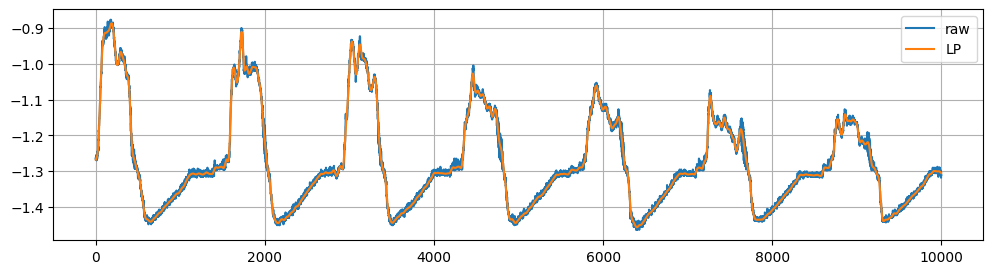

In [17]:
plt.figure(figsize=(12, 3))
plt.plot((isoforce_py.torque_raw[40_000:50_000]), label="raw")
plt.plot((isoforce_py.torque[40_000:50_000]), label="LP")
plt.legend()
plt.grid()

**Sync `isoforce_iso` with `isoforce_py`**

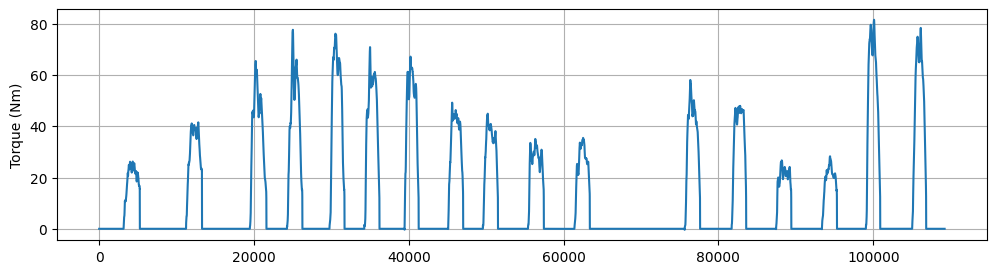

In [19]:
plt.figure(figsize=(12, 3))
plt.grid()
plt.plot(isoforce_iso.torque)
plt.ylabel("Torque (Nm)")
plt.show()

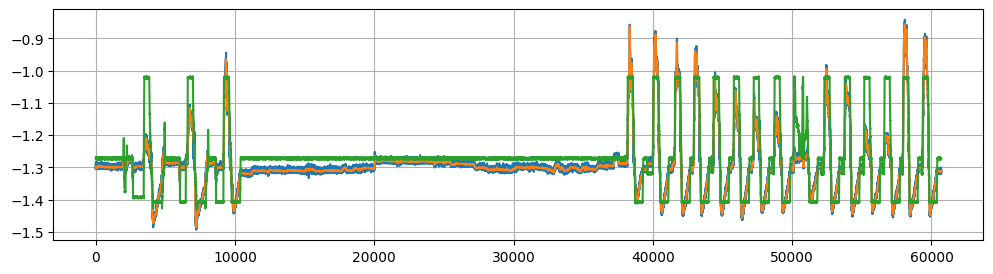

In [21]:
plt.figure(figsize=(12, 3))
plt.plot((isoforce_py.torque_raw[:]))
plt.plot((isoforce_py.torque[:]))
plt.plot(isoforce_py.speed)
plt.grid()

In [28]:
from src.postprocessing import lowpass_filter, scale_to_range
from scipy.signal import find_peaks


def rising_edge_detection(signal):
    signal = np.asarray(signal)
    diff = np.diff(signal)
    rising_edges = np.where(diff == 1)[0]
    return rising_edges

In [29]:
angle_py = isoforce_py.angle
torque_py = isoforce_py.torque

In [30]:
# speed_py = scale_to_range(speed_py)
torque_py = isoforce_py.torque
torque_py = scale_to_range(torque_py)

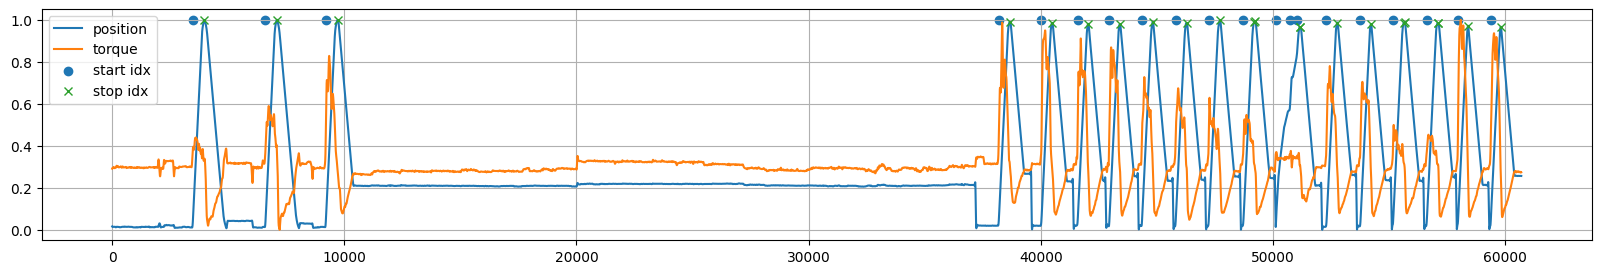

In [31]:
scaling_factor = 350
angle_py = scale_to_range(lowpass_filter(angle_py))
position_scaled = angle_py * scaling_factor

k = np.arange(len(position_scaled))
dpos_dk = np.round(np.gradient(position_scaled, k))
dpos_dk[dpos_dk <= 0] = 0
dpos_dk[dpos_dk > 1] = 1
dpos_dk = np.round(dpos_dk)

start_idxs = rising_edge_detection(dpos_dk)
stop_idxs, _ = find_peaks(angle_py, height=0.9)

# to_short = np.where(stop_idxs - start_idxs < 100)[0]
# to_long = np.where(stop_idxs - start_idxs > 2500)[0]
# cut_out = np.concatenate([to_short, to_long])
# stop_idxs = np.delete(stop_idxs,cut_out)
# start_idxs = np.delete(start_idxs,cut_out)

plt.figure(figsize=(20, 3))
startseg = 0_000
stopseg = 10_000
plt.plot(angle_py, label="position")
plt.plot(torque_py, label="torque")
# plt.plot(dpos_dk)

plt.scatter(start_idxs, np.ones(len(start_idxs)), label="start idx")
plt.plot(stop_idxs, angle_py[stop_idxs], "x", label="stop idx")

plt.legend()
plt.grid()

In [32]:
print(len(start_idxs), len(stop_idxs))

20 22


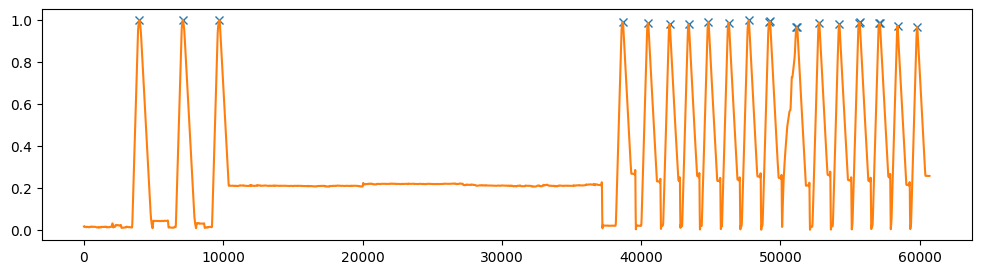

In [34]:
plt.figure(figsize=(12, 3))
plt.plot(stop_idxs, angle_py[stop_idxs], "x")
plt.plot(angle_py)
plt.show()

In [37]:
start_idxs.shape

(20,)

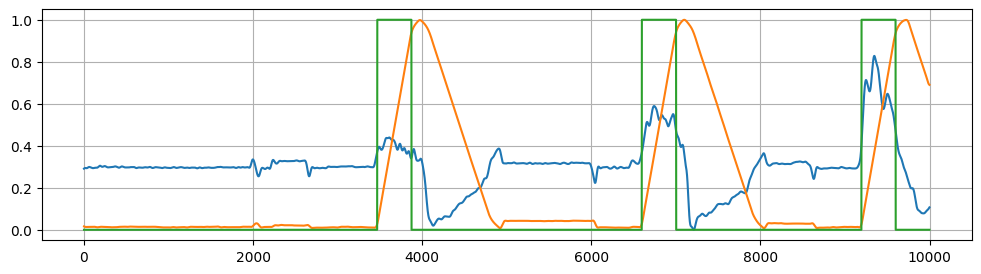

In [38]:
plt.figure(figsize=(12, 3))
plt.grid()
plt.plot(torque_py[startseg:stopseg])
plt.plot(lowpass_filter(angle_py[startseg:stopseg]))
plt.plot(dpos_dk[startseg:stopseg])

**Value alignment**

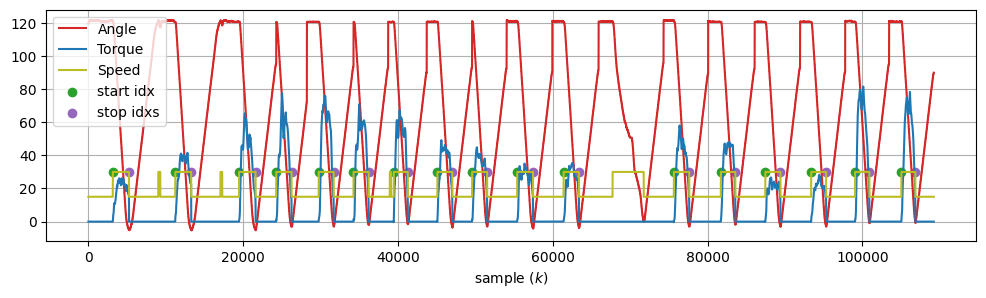

In [39]:
isoforce_iso.plot_data()

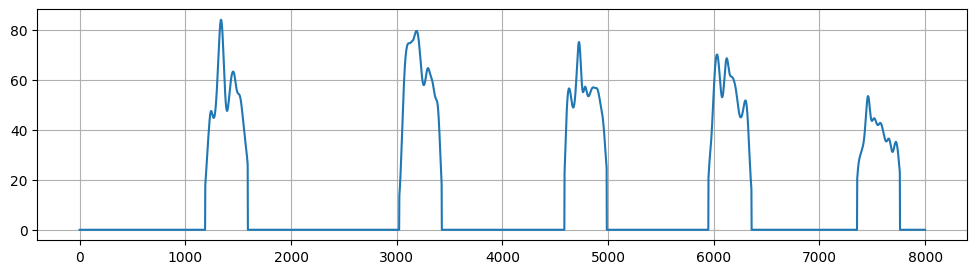

In [41]:
plt.figure(figsize=(12, 3))
plt.plot(
    (scale_to_range(isoforce_py.torque[37000:45000]) * 108 - 24) * dpos_dk[37000:45000]
)
plt.grid()